# Readme
---- This is the code for predicting aesthetic scores using the method in this paper: 
Bin, Jin, Maria V., Ortiz Segovia, and Sabine, Süsstrunk. "Image aesthetic predictors based on weighted CNNs." IEEE International Conference on Image Processing (ICIP), 2016.

---- To use the code, you need to install the following packages: Tensorflow(>=0.11.0), Keras(>=1.2.0), numpy, opencv

---- Install the newest CUDA and cudnn if you need GPU computation.

---- To run the code: please download the weights from our project webpage. 

---- This code is only for acamedic research use. All rights reserved by the authors.

---- Created by Bin Jin. Feb. 27th, 2016.

In [1]:
from __future__ import division

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2, os, random, time

## set global parameters: backend and image_dim_ordering for keras, and the gpu configuration
import os
os.environ['KERAS_BACKEND'] = 'tensorflow' # or 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from keras import backend as K
import tensorflow as tf
K.set_image_dim_ordering('tf')

## create a session for tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.allow_soft_placement = True
config.log_device_placement = False
sess = tf.Session(config=config)
K.set_session(sess)

## import keras layers
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.layers import Dense, Input, GlobalAveragePooling2D

Using TensorFlow backend.


##### load the network with pre-trained weights

In [2]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [3]:
path_weights = '/data/bjin/MyAesthetics/model_weights/' # point to where you download the weights file

input_tensor = Input(shape=(224, 224, 3))
base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(1,init='glorot_uniform',activation='sigmoid')(x) # in the range of 0 to 1
model = Model(input=input_tensor, output=x)
model.load_weights(path_weights + 'AVA_Xception_score_sigmoid.hdf5')
model.compile(optimizer='adam', loss='mse')


##### code for predicting the aesthetic score ( in the range of 0 to 1, 1 means good and 0 represents bad)

(183, 276, 3)


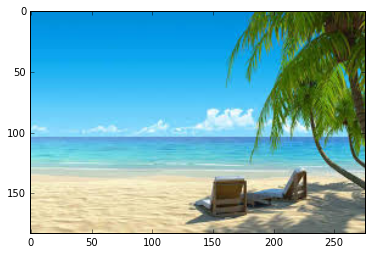

Holiday.jpeg: [[ 0.41127697]]


In [4]:
path_images = './'
filename = 'Holiday.jpeg' ## specify your own image

img = cv2.imread(path_images + filename)
print img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

img = cv2.resize(img.astype(np.float32),(224,224))
img = np.expand_dims(preprocess_input(img),axis=0)
score = model.predict(img)

print filename + ':', score

##### code for cropping the input image for aesthetic appealingness

In [5]:
## function for generating crop:
## Inputs:
##     ---- img: the input image, the format should be (height, width, 3)
##     ---- model: the aesthetics prediction model
##     ---- n_crops_attemp: number of random crops to choose from, the more, the slower
##     ---- aespect_ratio_h, aespect_ratio_w: the aespect ratio number for the height and width, the generated crop will
##                                            be in the aespect ratio of: aespect_ratio_h:aespect_ratio_w (e.g. 16:9)
##     ---- length_constrain: constrain the minsize of the crop to be larger than a percentage of the width or height.
##
## Outputs:
##     ---- crop_best: the generated best crop of the input image
##     ---- score_best: the aesthetics score of the returned crop, in range (0,1)

def generate_crop(img, model, n_crops_attemp=250, aespect_ratio_h=9, aespect_ratio_w=16,length_constrain = 0.5):
    
    [h,w,c] = img.shape
    images_batch = np.zeros((n_crops_attemp,224,224,3),np.float32)
    coordinates_batch = np.zeros((n_crops_attemp,4),dtype=np.uint16)
    min_sz_step = int(min(h/aespect_ratio_h, w/aespect_ratio_w))
    
    for crop_counter in range(n_crops_attemp):
        temp = random.randint(int(min_sz_step/2),min_sz_step)
        h_temp =  temp * aespect_ratio_h
        w_temp = temp * aespect_ratio_w
        start_h = random.randint(0,h-h_temp)
        start_w = random.randint(0,w-w_temp)
        end_h = start_h + h_temp
        end_w = start_w + w_temp
        img_crop = img[start_h:end_h,start_w:end_w,:]
        img_crop = cv2.resize(img_crop,(224,224))

        images_batch[crop_counter] = img_crop
        coordinates_batch[crop_counter] = [start_h, start_w, end_h,end_w]

    scores_batch = model.predict(preprocess_input(images_batch),batch_size=128)[:]
    score_batch_bestidx = np.argmax(scores_batch)
    [start_h,start_w,end_h,end_w] = coordinates_batch[score_batch_bestidx]
    crop_best = img[start_h:end_h,start_w:end_w,:]
    score_best = scores_batch[score_batch_bestidx]
    return crop_best, score_best

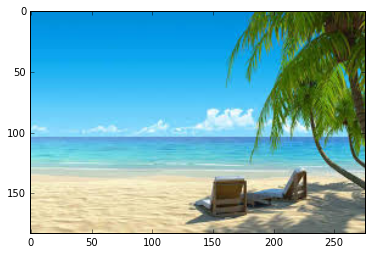

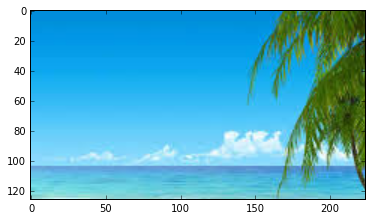

[ 0.46477821]


In [7]:
path_images = './'
filename = 'Holiday.jpeg' ## specify your own image

img = cv2.imread(path_images + filename)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

[crop_best,score_best] = generate_crop(img, model, n_crops_attemp=100)
plt.imshow(cv2.cvtColor(crop_best, cv2.COLOR_BGR2RGB))
plt.show()
print score_best